# Run the experiment
After processing the data, the neural network can be trained

__Remark: If you have not ran the previous notebook, some of the datafiles may not have been created. Please make sure to have run every notebook at least once in order, to make sure every datafile exists.__

## Setting up the model

In [10]:
import sys
import h5py
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

sys.path.append('../')

In [11]:
from src.model.LSTMnn import LSTMnn

Retrieve the datasets:

In [12]:
def load_training_sets(fname='../data/processed/datasets.h5'):
    with h5py.File(fname, 'r') as f:
        train_in = f['train_sets/train_in'][:]
        train_out = f['train_sets/train_out'][:]
        valid_in = f['valid_sets/valid_in'][:]
        valid_out = f['valid_sets/valid_out'][:]
    return train_in, train_out, valid_in, valid_out

train_in, train_out, valid_in, valid_out = load_training_sets()

Now define the hyperparameters that are used during the training of the neural network

In [13]:
time_forward = train_out.shape[2]
time_back = train_in.shape[1]
num_epochs = 30
hidden_size = 50
momentum = 0.8
num_layers = 1
learning_rate = 0.0003
batch_size = 64
num_feat = train_in.shape[2]

The numpy datasets need to be converted to pytorch tensors.

In [14]:
def numpy_to_dataloader(input_, output_, batch_size=64):
    set_ = TensorDataset(torch.Tensor(input_), torch.Tensor(output_))
    return DataLoader(set_, batch_size=batch_size, shuffle=True)

train = numpy_to_dataloader(train_in, train_out, batch_size)
valid = numpy_to_dataloader(valid_in, valid_out, 1024)

Next the model is set up. A criterion and optimizer is defined, using the hyperparameters previously defined

In [15]:
model = LSTMnn(num_feat, num_layers, hidden_size, time_forward)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, momentum=momentum)

## Training the model

In [16]:
def train_model(model, epochs, training, validation, criterion, optimizer, file_path=None, verbal=False):
    '''Train the model, using validation set for best selection
    The model is trained on the training data. Each epoch, the model is than used to predict the validation data.
    The best iteration of the model is stored and returned after going through every epoch.
    If a file_path is given, the best model configuration is stored in a file.
    '''
    min_val = np.inf
    best_loss = np.inf
    best_epoch = 0
    best_model = None
    for t in range(epochs):
        running_loss = 0
        model.train()
        for x, y in training:
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        if verbal:
            print('Epoch {}: Training loss: {}'.format(t, running_loss/len(training.dataset)))

        model.eval()
        with torch.no_grad():
            val_loss = 0
            for val_in, val_out in validation:
                y_pred = model(val_in)
                loss = criterion(val_out, y_pred)
                val_loss += loss.item()
            if verbal:
                print('Validation loss: ', val_loss / len(validation.dataset))
            if val_loss < min_val:
                min_val = val_loss
                best_loss = running_loss/len(training.dataset)
                best_epoch = t
                best_model = model.state_dict()
    if file_path is not None:
        torch.save(best_model, file_path)
    print('Best loss: {}, Min validation loss: {}, Epoch: {}'.format(best_loss, min_val, best_epoch))

    model.load_state_dict(best_model)

To save time, the neural network has already been trained and the model file has been added to the neural network model. In case you want to run the model yourself, please remove the # from the following cell:

In [17]:
#model_file = '../models/notebook_model'
#train_model(model, num_epochs, train, valid, criterion, optimizer, verbal=True, file_path=model_file)

## Testing the model

First the test data is loaded and the model is used to create a forecast.

In [18]:
def load_testing_sets(fname='../data/processed/datasets.h5'):
    with h5py.File(fname, 'r') as f:
        test_in = f['test_sets/test_in'][:]
        test_out = f['test_sets/test_out'][:]
        lookup = f['test_sets/lookup'][:]
    return test_in, test_out, lookup.astype('datetime64[s]')

def run_model(model, data_in, file_path=None):
    if file_path is not None:
        model.load_state_dict(torch.load(file_path))
    model.eval() 
    pred = model(torch.Tensor(data_in))
    return pred.detach().numpy()

test_in, test_out, lookup = load_testing_sets()
predict = run_model(model, test_in, file_path='../models/notebook_model')

In [19]:
import pandas as pd
from src.model.metrics import evaluate
ev = evaluate(predict[:, 0], test_out[:, 0])
pd.DataFrame(data=ev, index=['t+{}'.format(i+1) for i in range(6)])

,A,B,sigmaA,sigmaB,R,RMSE,MAE,ME,PE
t+1,-0.800090,0.964531,0.122654,0.005490,0.979564,3.783515,2.395328,-0.367407,0.959134
t+2,-1.362862,0.914209,0.119820,0.005367,0.949787,5.864859,3.867075,-0.316640,0.901647
t+3,-2.048730,0.863553,0.116979,0.005244,0.918138,7.424476,4.906576,-0.385527,0.842050
t+4,-2.567327,0.823017,0.114788,0.005151,0.890910,8.507734,5.582392,-0.411385,0.792152
t+5,-2.949336,0.791624,0.113210,0.005084,0.868194,9.297385,6.044968,-0.412610,0.751369
t+6,-3.339964,0.760047,0.111314,0.005002,0.847274,9.951035,6.409562,-0.420952,0.714886


##  Observe the forecasted storms

In [20]:
def load_test_storm_dates(fname='../data/processed/datasets.h5'):
    with h5py.File(fname, 'r') as f:
        test_storm_dates = f['test_sets/storms/storm_dates'][:]
    return test_storm_dates.astype('datetime64')

test_storm_dates = load_test_storm_dates()

In [21]:
test_storm_dates = test_storm_dates.astype('datetime64')

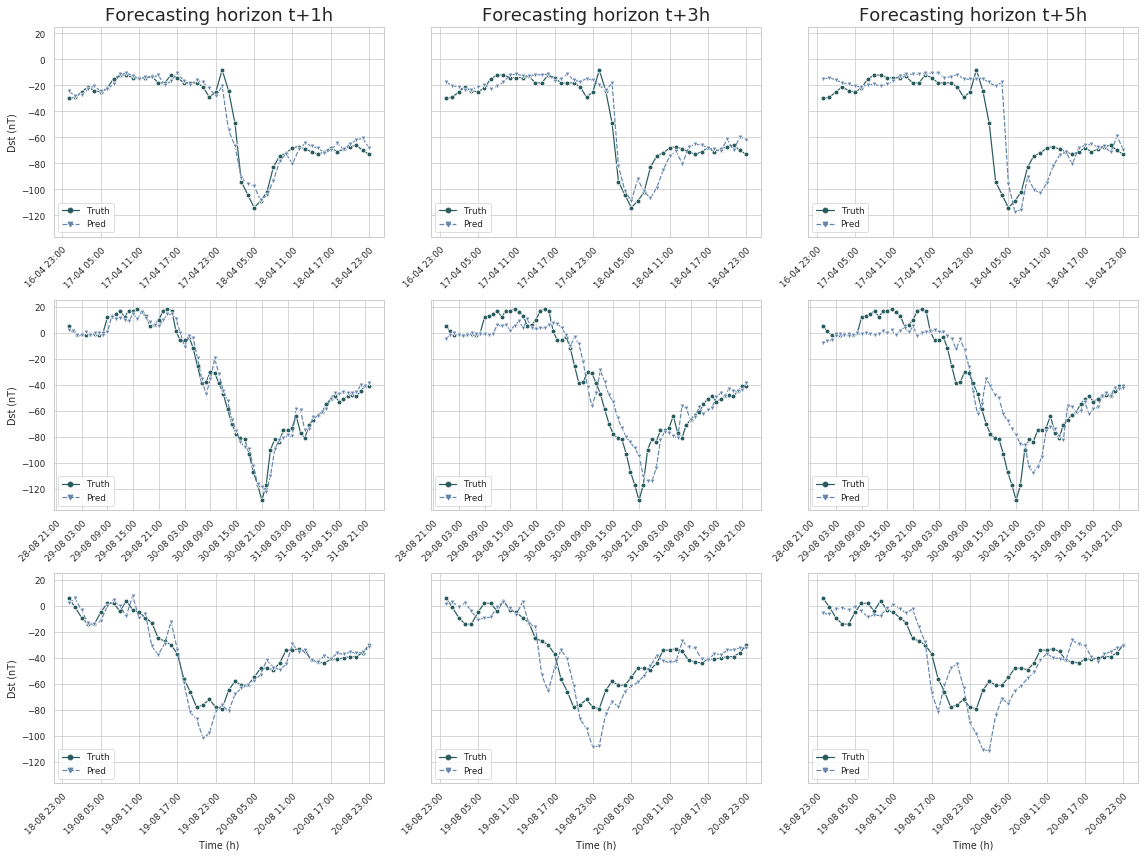

In [22]:
from src.visualize.visualize import plot_set_of_storms
times = [0, 2, 4]
selected_storms = [test_storm_dates[0], test_storm_dates[7], test_storm_dates[13]]
plot_set_of_storms(test_out[:, 0], predict[:, 0], lookup, selected_storms, times, save=False)

### Store the results

In [25]:
def save_test_forecast(fname='../data/processed/datasets.h5'):
    with h5py.File(fname, 'a') as f:
        try:
            f['test_sets'].create_dataset('prediction', data=predict)
        except:
            print('File already has the dataset test_sets/prediction. Overwriting...')
            del f['test_sets/prediction']
            f['test_sets'].create_dataset('prediction', data=predict)
                
save_test_forecast()

File already has the dataset test_sets/prediction. Overwriting...
